# Data conversion script
Convert data from TFRecord with nonstand data format to a standard one

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# frontend imports
from keras_yolov2.yolo_loss import YoloLoss
from keras_yolov2.map_evaluation import MapEvaluation
from keras_yolov2.utils import decode_netout, import_feature_extractor, import_dynamically
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_yolov2.frontend import YOLO
from keras_yolov2.preprocessing import BatchGenerator
from keras_yolov2.custom_backend import ResNet50CustomFeature
import numpy as np
import sys
import cv2
import os

# preprocessing imports
import copy
import os
import xml.etree.ElementTree as et

import cv2
import numpy as np
from imgaug import augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

from keras_yolov2.utils import BoundBox, bbox_iou
import random
from tfdeterminism import patch
patch()
SEED = 234534
random.seed(SEED)
tf.random.set_random_seed(SEED)
np.random.seed(SEED)

/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/vol/tensusers2/sdoope

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Input configurations

paths to data and config constants

In [3]:
# Yolo class input parameters
config = {
    "model" : {
        "backend":              "./keras_yolov2/custom_backend.ResNet50CustomFeature",
        "input_size_w":         257,
        "input_size_h":         257,
        "gray_mode":            False,
        "anchors":              [5.11111, 4.111111, 9.22222, 11.7777, 15.6666, 6.77777, 8.22222, 4.33333, 4.44444, 7.44444],
        #"anchors":              [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
        "max_box_per_image":    10,        
        "labels":               ["dam"]
    },

    "parser_annotation_type":    "xml",

    "train": {
        "train_csv_file":       "",
        "train_csv_base_path":  "",
        "train_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_image_folder",
        "train_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_annot_folder",     

        "callback":             None,
        "train_times":          8,
        "pretrained_weights":   "",
        "batch_size":           16,
        "learning_rate":        1e-4,
        "nb_epochs":            40,
        "warmup_epochs":        3,

        "workers":              12,
        "max_queue_size":       40,
        "early_stop":           True,
        "tensorboard_log_dir":  "./logs/1",

        "object_scale":         5.0 ,
        "no_object_scale":      1.0,
        "coord_scale":          1.0,
        "class_scale":          1.0,

        "saved_weights_name":   "tiny_yolo_backend_best.h5",
        "debug":                False
    },

    "valid": {
        "iou_threshold":        "0.5",
        "score_threshold":      "0.5",
        "valid_csv_file":       "",
        "valid_csv_base_path":  "",
        "valid_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_image_folder",
        "valid_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_annot_folder",

        "valid_times":          1
    },

    "backup":{
        "create_backup":        True,
        "redirect_model":       True,
        "backup_path":          "../backup",
        "backup_prefix":        "Tiny_yolo_VOC"
    }
}


input_size = [257,257,5]

In [4]:
input_path = '../datasets/bbox_data/train/*.gz'

input_files= glob(input_path)
#print("input path is ", input_files)
print(input_files[0:10])


['../datasets/bbox_data/train/dam-data-000.gz', '../datasets/bbox_data/train/dam-data-001.gz', '../datasets/bbox_data/train/dam-data-002.gz', '../datasets/bbox_data/train/dam-data-003.gz', '../datasets/bbox_data/train/dam-data-004.gz', '../datasets/bbox_data/train/dam-data-005.gz', '../datasets/bbox_data/train/dam-data-006.gz', '../datasets/bbox_data/train/dam-data-007.gz', '../datasets/bbox_data/train/dam-data-008.gz', '../datasets/bbox_data/train/dam-data-009.gz']


In [5]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),
        'image/object/bbox/xmin': tf.io.FixedLenFeature(1, dtype=tf.int64), 
        'image/object/bbox/xmax': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/bbox/ymin': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/bbox/ymax': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/class/text': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/object/class/label': tf.io.FixedLenFeature(1, dtype=tf.int64)
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)

def parse_features(feature):
    features = [feature[x] for x in ['image/width', 'image/height', 'image/filename', 'image/object/class/label']]
    
    # locations
    xmin = feature['image/object/bbox/xmin']
    xmax = feature['image/object/bbox/xmax']
    ymin = feature['image/object/bbox/ymin']
    ymax = feature['image/object/bbox/ymax']
    class_name = feature['image/object/class/text']
    
    obj = tf.concat([xmin, xmax, ymin, ymax], axis=0)
    pixel_label = feature['image/channel/PIXEL_LABEL']
    return obj

In [6]:
dataset = tf.data.TFRecordDataset(input_files[0], compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
dataset = dataset.map(parse_features)


for x in dataset.take(1):
    print(x)

tf.Tensor([109 147  97 160], shape=(4,), dtype=int64)


## YOLO frontend

adjusted yolo frontend code

In [7]:
print(input_size)
yolo = YOLO(config['model']['backend'], 
            input_size, config['model']['labels'], 
            config['model']['max_box_per_image'], 
            config['model']['anchors'], 
            gray_mode=False)


[257, 257, 5]


/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


loading backend weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, 257, 257, 5)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 257, 3)       18        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
Total params: 23,587,730
Trainable params: 23,534,610
Non-trainable params: 53,120
_________________________________________________________________
Using a custom backend called custom_backend.ResNet50CustomFeature.
(9, 9)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 257, 257, 5)]     0         
____________________________________________________________

In [8]:
generator_config = {
    'IMAGE_H': yolo._input_size[0],
    'IMAGE_W': yolo._input_size[1],
    'IMAGE_C': yolo._input_size[2],
    'GRID_H': yolo._grid_h,
    'GRID_W': yolo._grid_w,
    'BOX': yolo._nb_box,
    'LABELS': yolo.labels,
    'CLASS': len(yolo.labels),
    'ANCHORS': yolo._anchors,
    'BATCH_SIZE': 10,
    'TRUE_BOX_BUFFER': yolo._max_box_per_image,
}


pprint(generator_config)


{'ANCHORS': [5.11111,
             4.111111,
             9.22222,
             11.7777,
             15.6666,
             6.77777,
             8.22222,
             4.33333,
             4.44444,
             7.44444],
 'BATCH_SIZE': 10,
 'BOX': 5,
 'CLASS': 1,
 'GRID_H': 9,
 'GRID_W': 9,
 'IMAGE_C': 5,
 'IMAGE_H': 257,
 'IMAGE_W': 257,
 'LABELS': ['dam'],
 'TRUE_BOX_BUFFER': 10}


## Yolo batch generator

In [23]:
batch = BatchGenerator(input_files[1:2], generator_config)

dataset = batch(mode='train')
print(dataset)

for x in dataset.take(1):
    print(x)

<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>
(<tf.Tensor: id=30775, shape=(10, 257, 257, 5), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.

In [24]:
for img, label in dataset.take(1):
    preds = yolo._model.predict(img)

print(preds)

[[[[[ 2.37288699e-01  6.78369850e-02  1.51370186e-02 -6.24213219e-01
     -9.94919762e-02 -1.28335506e-01]
    [-5.82132518e-01  2.62951344e-01 -7.08715394e-02 -1.10304669e-01
     -1.04624696e-01  7.22517073e-02]
    [ 5.33478677e-01  1.91235840e-01  5.33063471e-01 -1.10017717e-01
      1.25753105e-01 -5.91519382e-03]
    [ 3.52779806e-01  2.21028328e-01  8.20082963e-01  3.36961865e-01
     -5.45347445e-02  1.14099756e-01]
    [ 3.58217329e-01 -7.28588179e-02  4.42345679e-01  9.47113812e-01
     -7.39885747e-01  3.24947715e-01]]

   [[-4.31881100e-03  3.83988135e-02 -2.07208507e-02  4.99187857e-02
      5.91525026e-02  6.02567531e-02]
    [-3.16932015e-02 -1.30602745e-02 -7.73805603e-02  6.19359314e-02
      5.99655509e-03  1.36805736e-02]
    [-9.08532739e-03  7.04836193e-03  6.55893758e-02  2.34001782e-02
     -1.10689234e-02  3.50049734e-02]
    [ 1.09617962e-02 -4.53063101e-03  1.44672394e-02  1.04488119e-01
     -7.73454010e-02  1.01502519e-02]
    [ 4.82863300e-02 -4.32147877e-0

## plot images from the functions

the bounding box is supposed to be wrong when augmented since it is not the transformed box


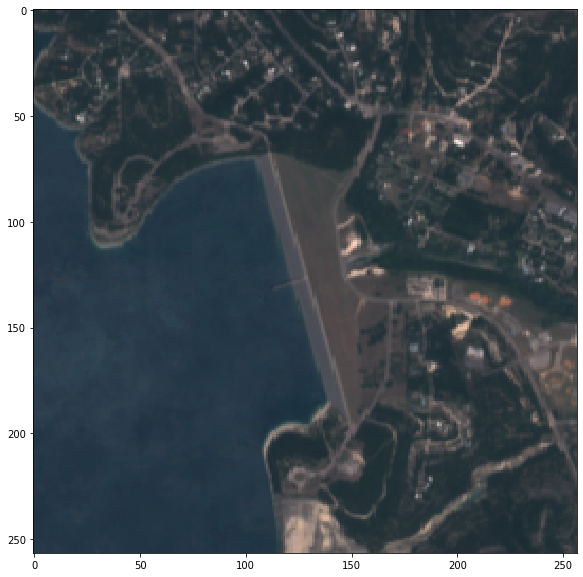

In [25]:
for image,y_batch in dataset.take(1):
    image = image[0,...]
    #print(y_batch)

    #all_objs = all_objs[0]
    #bbox = BoundBox(all_objs.numpy()[0],all_objs.numpy()[2] , all_objs.numpy()[1], all_objs.numpy()[3] )


# get bounding boxes in matplotlib format
#plt_boxes = get_matplotlib_boxes([bbox],image.numpy().shape)
# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image.numpy()[:,:,0:3].squeeze(), cmap='gray')

print("the bounding box is supposed to be wrong when augmented since it is not the transformed box")
#or plt_box in plt_boxes:
#    ax.add_patch(plt_box)
#    #ax.imshow(pixel_label)
#plt.show()

In [12]:
# with pretrained backend

yolo.train(train_imgs = input_files[0:20],
           valid_imgs = input_files[50:55],
           train_times= 1,
           valid_times= 1,
           nb_epochs= 4,
           learning_rate= 0.00001,
           batch_size= 10,
           warmup_epochs= 3 ,
           object_scale= 5.0,
           no_object_scale=1.0,
           coord_scale=1.0,
           class_scale=1.0)

Instructions for updating:
Use `tf.cast` instead.


KeyboardInterrupt: 

In [ ]:
# tensorboard metrics same tags keras
for i, (image,y_batch) in enumerate(dataset.take(1)):
    z = image
    y = y_batch
    print(np.squeeze(z.numpy()).shape)

In [13]:
for image, bbox, class_name, labels in dataset.take(1):
    print(class_name)
    print(labels)
    


ValueError: not enough values to unpack (expected 4, got 2)

In [12]:
def load_annotation(bbox, class_name, labels=['dam_image']):
    bbox = np.squeeze(bbox.numpy())
    class_name = np.squeeze(class_name.numpy(), axis=0)
    class_name = [x.decode("utf-8") for x in class_name]
    class_name = [labels.index(x) for x in class_name] # convert to integers
    all_objs = np.array([np.concatenate([bbox, class_name], axis=0)])
    
    # this is a conversion to xmin ymin xmax ymax!!!
    # DOES NOT WORK FOR MULTIPLE OBJECTS IN ONE IMAGE
    # but then again, the entire program is not build for it :)
    
    annots = []
    for obj in all_objs:
        annot = [obj[0], obj[2], obj[1], obj[3], obj[4]]
        annots += [annot]

    if len(annots) == 0:
        annots = [[]]

    return np.array(annots)
    


load_annotation(bbox, class_name)

NameError: name 'bbox' is not defined

## Generate anchor boxes for dataset

In [11]:
def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)

def parse_features(feature):
    features = [feature[x] for x in ['image/width', 'image/height', 'image/filename', 'image/object/class/label']]
    col_channel = [feature[x] for x in ['image/channel/B4', 'image/channel/B3', 'image/channel/B2']]
    mndwi_chan = [feature[x] for x in ['image/channel/MNDWI']]
    ave_chan = [feature[x] for x in ['image/channel/AVE']]
    
    # locations
    xmin = feature['image/object/bbox/xmin']
    xmax = feature['image/object/bbox/xmax']
    ymin = feature['image/object/bbox/ymin']
    ymax = feature['image/object/bbox/ymax']
    
    obj = tf.concat([xmin, xmax, ymin, ymax], axis=0)
    pixel_label = feature['image/channel/PIXEL_LABEL']
    img = tf.transpose(tf.squeeze(tf.stack(col_channel)) , perm=[1, 2, 0])
    img = stretch_image_colorspace(img)
    
    
    # MNDWI normalization
    mndwi_chan = tf.divide(tf.add(mndwi_chan, 1), 1 + 1)
    img = tf.concat([img, tf.transpose(mndwi_chan, perm=[1,2,0])], axis= 2)
        
    # AVE normalization
    ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
    img = tf.concat([img, tf.transpose(ave_chan, perm=[1,2,0])], axis= 2)
    
    return obj, pixel_label, img

In [12]:
dataset = tf.data.TFRecordDataset(input_files, compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
# [xmin, xmax, ymax, ymin]
#parse features extracts the bounding boxes

dataset = dataset.map(parse_features)


#for i, (x, pixel, img) in enumerate(dataset):
#    print(i, x)

### Functions from gen_anchors.py

In [13]:
num_anchors = 10

img_width = 257
img_height = 257

# if config = tfrecord

input_size = (config['model']['input_size_h'], config['model']['input_size_w'], 3)
feature_extractor = import_feature_extractor(config['model']['backend'], input_size)
grid_w = config['model']['input_size_w']/feature_extractor.get_output_shape()[1]
grid_h = config['model']['input_size_h']/feature_extractor.get_output_shape()[0]

print("grid_w, grid_h = ({},{})".format(grid_w,grid_h))

# run k_mean to find the anchors
annotation_dims = []

for label, pixel_label, img in dataset:
    label = label.numpy()
    if label[0] == label[1] or label[2] ==label[3]:
        continue
    
    cell_w = img_width/grid_w
    cell_h = img_height/grid_h

    # 0: xmin, 1: xmax, 2: ymin, 3:ymax
    relative_w = (float(label[1]) - float(label[0]))/cell_w
    relative_h = (float(label[3]) - float(label[2]))/cell_h
    annotation_dims.append(tuple(map(float, (relative_w, relative_h))))
    
annotation_dims = np.array(annotation_dims)

''''''

/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


loading backend weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, 257, 257, 5)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 257, 3)       18        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
Total params: 23,587,730
Trainable params: 23,534,610
Non-trainable params: 53,120
_________________________________________________________________
Using a custom backend called custom_backend.ResNet50CustomFeature.
grid_w, grid_h = (28.555555555555557,28.555555555555557)


''

In [15]:
annotation_dims = np.array(annotation_dims)
print(annotation_dims)
print(annotation_dims.shape)

[[ 4.22222222  7.        ]
 [11.22222222  7.11111111]
 [ 7.88888889  4.        ]
 ...
 [ 3.22222222  3.88888889]
 [ 3.55555556  4.11111111]
 [ 3.66666667  4.55555556]]
(8000, 2)


 ## Another attempt

In [16]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median, verbose=True):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))
    old_distances = distances
    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]
    
    # if inf or nan values: one or more clusters have no assignments out of all data points
    # quite rare, but not impossible
    iteration = 0
    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)
            
        iteration += 1
        if verbose:
            print("iteration {}: old: {}, new: {}, diff {}".format(iteration, np.sum(old_distances), np.sum(distances), np.sum(np.abs(old_distances-distances))))
        
        nearest_clusters = np.argmin(distances, axis=1)
        
        
        if (last_clusters == nearest_clusters).all():
            break
        for cluster in range(k):

            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters
        old_distances = distances.copy()
        
        
    return clusters

In [19]:
new_anchors = kmeans(annotation_dims, 5)
print(new_anchors)

iteration 1: old: 24372.688568640035, new: 24372.688568640035, diff 0.0
iteration 2: old: 24372.688568640035, new: 23491.685906987474, diff 2357.9895392511967
iteration 3: old: 23491.685906987474, new: 23466.682958355777, diff 747.275674405058
iteration 4: old: 23466.682958355777, new: 23435.302076097294, diff 653.3172967192708
iteration 5: old: 23435.302076097294, new: 23391.039340418192, diff 440.3858671444549
iteration 6: old: 23391.039340418192, new: 23420.47409715116, diff 467.9459689051255
iteration 7: old: 23420.47409715116, new: 23432.945502202467, diff 380.6172186115112
iteration 8: old: 23432.945502202467, new: 23487.93732843228, diff 285.76176300428597
iteration 9: old: 23487.93732843228, new: 23522.947577109877, diff 246.4199537125605
iteration 10: old: 23522.947577109877, new: 23545.378281619847, diff 216.84193664674018
iteration 11: old: 23545.378281619847, new: 23585.633510667976, diff 267.11223151205155
iteration 12: old: 23585.633510667976, new: 23569.409396903342, dif

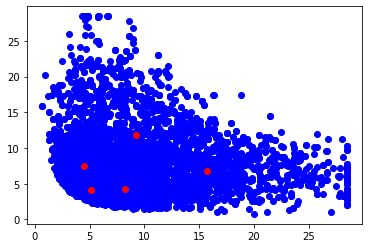

In [20]:
plt.plot(annotation_dims[:,0], annotation_dims[:,1], 'bo')
plt.plot(new_anchors[:,0], new_anchors[:,1], 'ro')

(array([], dtype=int64),)
0
tf.Tensor([  8 249  92 164], shape=(4,), dtype=int64)
nr objects 1
labeled [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


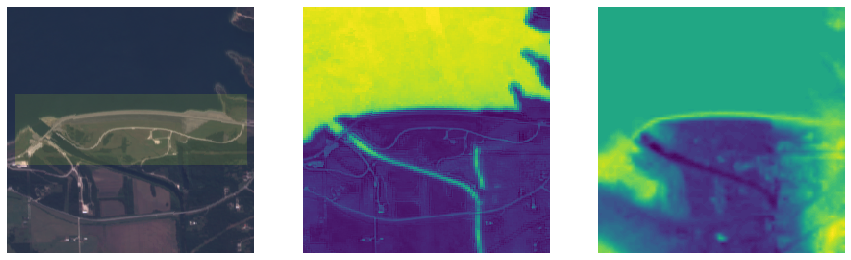

In [89]:
from scipy import ndimage
print(np.where(annotation_dims[:,1] < 0))

annotation_dims[27,0]
# [xmin, xmax, ymin ymax]

for i, (x, gt, img) in enumerate(dataset.take(6)):
    if i% 100 == 0:
        print(i)

print(x)

labeled, nr_objects = ndimage.label(gt.numpy()) 
print("nr objects", nr_objects)
print("labeled", labeled)

fig, axes = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0].imshow(gt)
axes[0].imshow(img[:,:,0:3], alpha=0.9)
axes[0].axis('off')
axes[1].imshow(img[:,:,3])
axes[1].axis('off')
axes[2].imshow(img[:,:,4])
axes[2].axis('off')
plt.show()
    


Number of objects is 2
labeled [[1 1 0 0]
 [0 0 0 0]
 [0 0 2 2]]


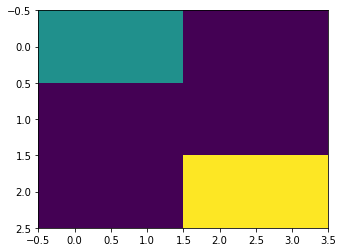

In [40]:
gt = np.array([[1,1,0,0],[0,0,0,0],[0,0,1,1]])


plt.imshow(gt)

# find connected components
labeled, nr_objects = ndimage.label(gt) 
print("Number of objects is {}".format(nr_objects))
print("labeled",labeled)
# Number of objects is 4 


plt.imshow(labeled)
plt.show()

## TODO
Learning rate scheduler for burn in period  
Anchor boxes tuning  
In GEE: remove overlapping samples?  
kijk alles na: zijn xmin, xmax, ymin, ymax nu goed?
De channels zijn getransposed, dit moet niet!!! onjuiste bbox!



0.002685070960097003


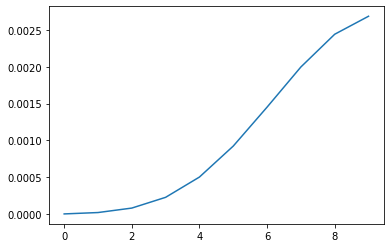

In [28]:
def schedule(epoch, lr):   
    if epoch == 0:
        learning_rate = lr 
        
    elif epoch != 0 and epoch < 11:
        learning_rate = lr * (11 / (epoch +1))
    
    if epoch >= 11:
        decay_rate = 0.0005
        learning_rate = lr /(1+decay_rate*epoch)

    return learning_rate
    
y = []

#start lr
lr = 0.0005

for x in range(0,10):
    y.append(schedule(x,lr))
    lr = y[-1]
    
    
plt.plot(y)
print(y[-1])


In [13]:
class LearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

    Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.start_lr = self.model.optimizer

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
            
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr, start_lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print('\nEpoch %05d: Learning rate is %6.4f.' % (epoch, scheduled_lr))
        


0.0002240625640325115


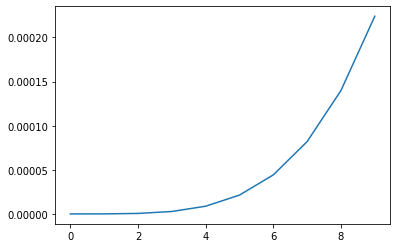

In [15]:
def schedule(epoch, lr, start_lr):   
    if epoch <11:
        learning_rate = start_lr * (epoch / 11) ** 4 
    
    if epoch >= 11:
        decay_rate = 0.0005
        learning_rate = lr /(1+decay_rate*epoch)

    return learning_rate
    
y = []

#start lr
lr = 0.0005
start_lr = 0.0005

for x in range(0,10):
    y.append(schedule(x,lr, start_lr))
    lr = y[-1]
    
    
plt.plot(y)
print(y[-1])

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler

In [10]:
inputs = keras.Input(shape=(784,), name='digits')
x = Dense(64, activation='relu', name='dense_1')(inputs)
x = Dense(64, activation='relu', name='dense_2')(x)
outputs = Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='3_layer_mlp')
model.summary()


Model: "3_layer_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr = 0.1))

lr_rate = LearningRateScheduler(schedule, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,
                    callbacks = [lr_rate])

print(history.history['lr'])

NameError: name 'schedule' is not defined